Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install scikit-plot

# If you're working locally:
else:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import numpy as np

# Wrangle the modeling data

# indicate_missing is a function that returns a boolean value if the inbound data = 'MISSING'
#   - helps in creating a "missing" column 
def indicate_missing(val):
  if val == 'MISSING':
    return True

  return False

# boolean_missing is a function converting the permit boolean column to categorical data 
def boolean_missing(val):
  if val == True:
    return 'TRUE'

  if val == False:
    return 'FALSE'

  return 'MISSING'

def wrangle(DF):
  X = DF.copy()

  # Replace near zero latitude values with zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # Replace zero values with nan so we can impute values downstream
  cols_with_zeroes = ['longitude',
                      'latitude',
                      'construction_year',
                      'gps_height',
                      'population']
  for col in cols_with_zeroes:
    X[col] = X[col].replace(0, np.nan)   # replace zeros with nans

  # Create columns for month and year recorded data
  X['date_recorded']  = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  X['year_recorded']  = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded']   = X['date_recorded'].dt.day

  # Create a column reflecting the number of years from construction to year recorded
  X['years']          = X['year_recorded'] - X['construction_year']
  X['years']          = X['years'].replace(0, np.nan)   # replace zeros with nans

  # Replace missing boolean data with categorical data reflecting that missing data
  cols_boolean_missing = ['public_meeting', 'permit']
  for col in cols_boolean_missing:
    X[col+'_CATEGORICAL']             = X[col].apply(boolean_missing)

  # Replace missing categorical data with 'MISSING'
  cols_categorical_missing = ['funder', 'installer', 'scheme_name', 'scheme_management', 'subvillage']
  for col in cols_categorical_missing:
    X[col]            = X[col].replace(np.nan, 'MISSING')

  # List columns to be dropped
  cols_drop = ['date_recorded',             # date_recorded - using year_recorded and month_recorded instead
               'quantity_group',            # duplicate column
               'payment_type',              # duplicate column
               'recorded_by',               # data collection process column (not predictive)
               'id',                        # data collection process column (not predictive)
               'public_meeting',            # replaced by categorical column: public_meeting_CATEGORICAL
               'permit',                    # replaced by categorical column: permit_CATEGORICAL
               'num_private',               # 98% zeroes, unclear the purpose of this dat
               'construction_year',         # use 'years' as a proxy
               'amount_tsh']                # highly skewed data
  # Also drop the columns we processed due to missing values
  cols_drop.extend(cols_boolean_missing)

  # Drop undesired columns
  X = X.drop(columns=cols_drop)

  return X

In [4]:
from sklearn.model_selection import train_test_split

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [5]:
# Wrangle train, validate, and test sets in the same way
df_train  = wrangle(train)
df_val    = wrangle(val)
df_test   = wrangle(test)
print(f'Training: {df_train.shape}, Validation: {df_val.shape}, Test: {df_test.shape}')

Training: (45042, 37), Validation: (14358, 37), Test: (14358, 36)


In [6]:
# Construct the X features matrix and y target vector
X_train = df_train.drop(columns=target)
y_train = df_train[target]
X_val   = df_val.drop(columns=target)
y_val   = df_val[target]
X_test  = df_test

In [7]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Configure a modeling pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [8]:
from sklearn.metrics import accuracy_score

# Fit the pipeline model on the training dataset
pipeline.fit(X_train, y_train)

# Generate model predictions using the validation dataset
y_pred = pipeline.predict(X_val)
print(f'Validation Accuracy: {round(accuracy_score(y_val, y_pred), 5)}')

Validation Accuracy: 0.81021


In [9]:
# Generate test dataset predictions
y_pred_test = pipeline.predict(X_test)

In [10]:
# Construct dataframe housing the Kaggle submission dataset
tmp_dict = {'id': list(test['id']), 'status_group': list(y_pred_test)}
df_submission = pd.DataFrame(tmp_dict)

In [11]:
# # Create submission csv (download and submit to Kaggle)
# df_submission.to_csv("submission_dfa.csv", index=False)

In [13]:
!pip install scikit-plot

<AxesSubplot:title={'center':'Confustion Matrix: N Obs=14358'}, xlabel='Predicted label', ylabel='True label'>

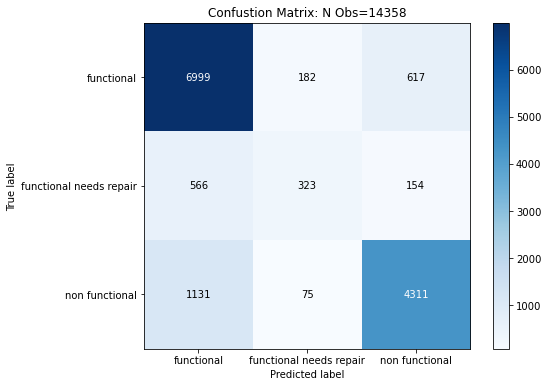

In [14]:
# Print out the confusion matrix
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_val, y_pred,
                      figsize=(8, 6),
                      title=f'Confustion Matrix: N Obs={len(y_val)}',
                      normalize=False)

<AxesSubplot:title={'center':'Confustion Matrix: N Obs=14358'}, xlabel='Predicted label', ylabel='True label'>

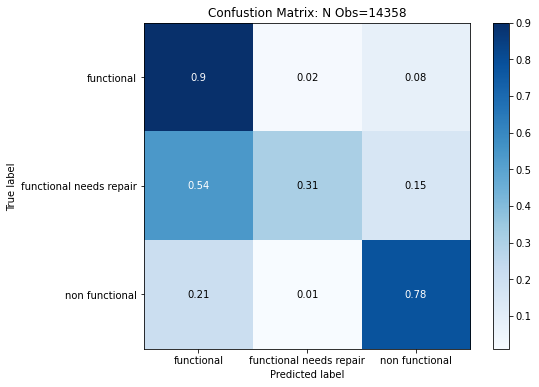

In [15]:
plot_confusion_matrix(y_val, y_pred,
                      figsize=(8, 6),
                      title=f'Confustion Matrix: N Obs={len(y_val)}',
                      normalize=True)

In [16]:
# Print out the classification report
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      7798
functional needs repair       0.56      0.31      0.40      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.66      0.69     14358
           weighted avg       0.80      0.81      0.80     14358

